**Part 3. AI Agent 심화 프로젝트**

- Chapter 03. GraphRAG

    - **📒[실습]** Clip 06. Graph 기반 GraphRAG 구현하기🗒️

## 🔗 Graph DB 연결하기

Crime Investigation Dataset: https://github.com/neo4j-graph-examples/pole

In [ ]:
from neo4j import GraphDatabase

# URI examples: "neo4j://localhost", "neo4j+s://xxx.databases.neo4j.io"
URI = "neo4j+s://xxx.databases.neo4j.io"
AUTH = ("neo4j", "<PASSWORD>") 


with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()

In [2]:
driver = GraphDatabase.driver(URI, auth=AUTH)

In [3]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

In [4]:
from neo4j_graphrag.llm.openai_llm import OpenAILLM

llm = OpenAILLM(model_name="gpt-4o")

## 🧑‍💻 Graph 기반 RAG 구현하기 : Text2Cypher

### 1️⃣ POLE 그래프 이해하기

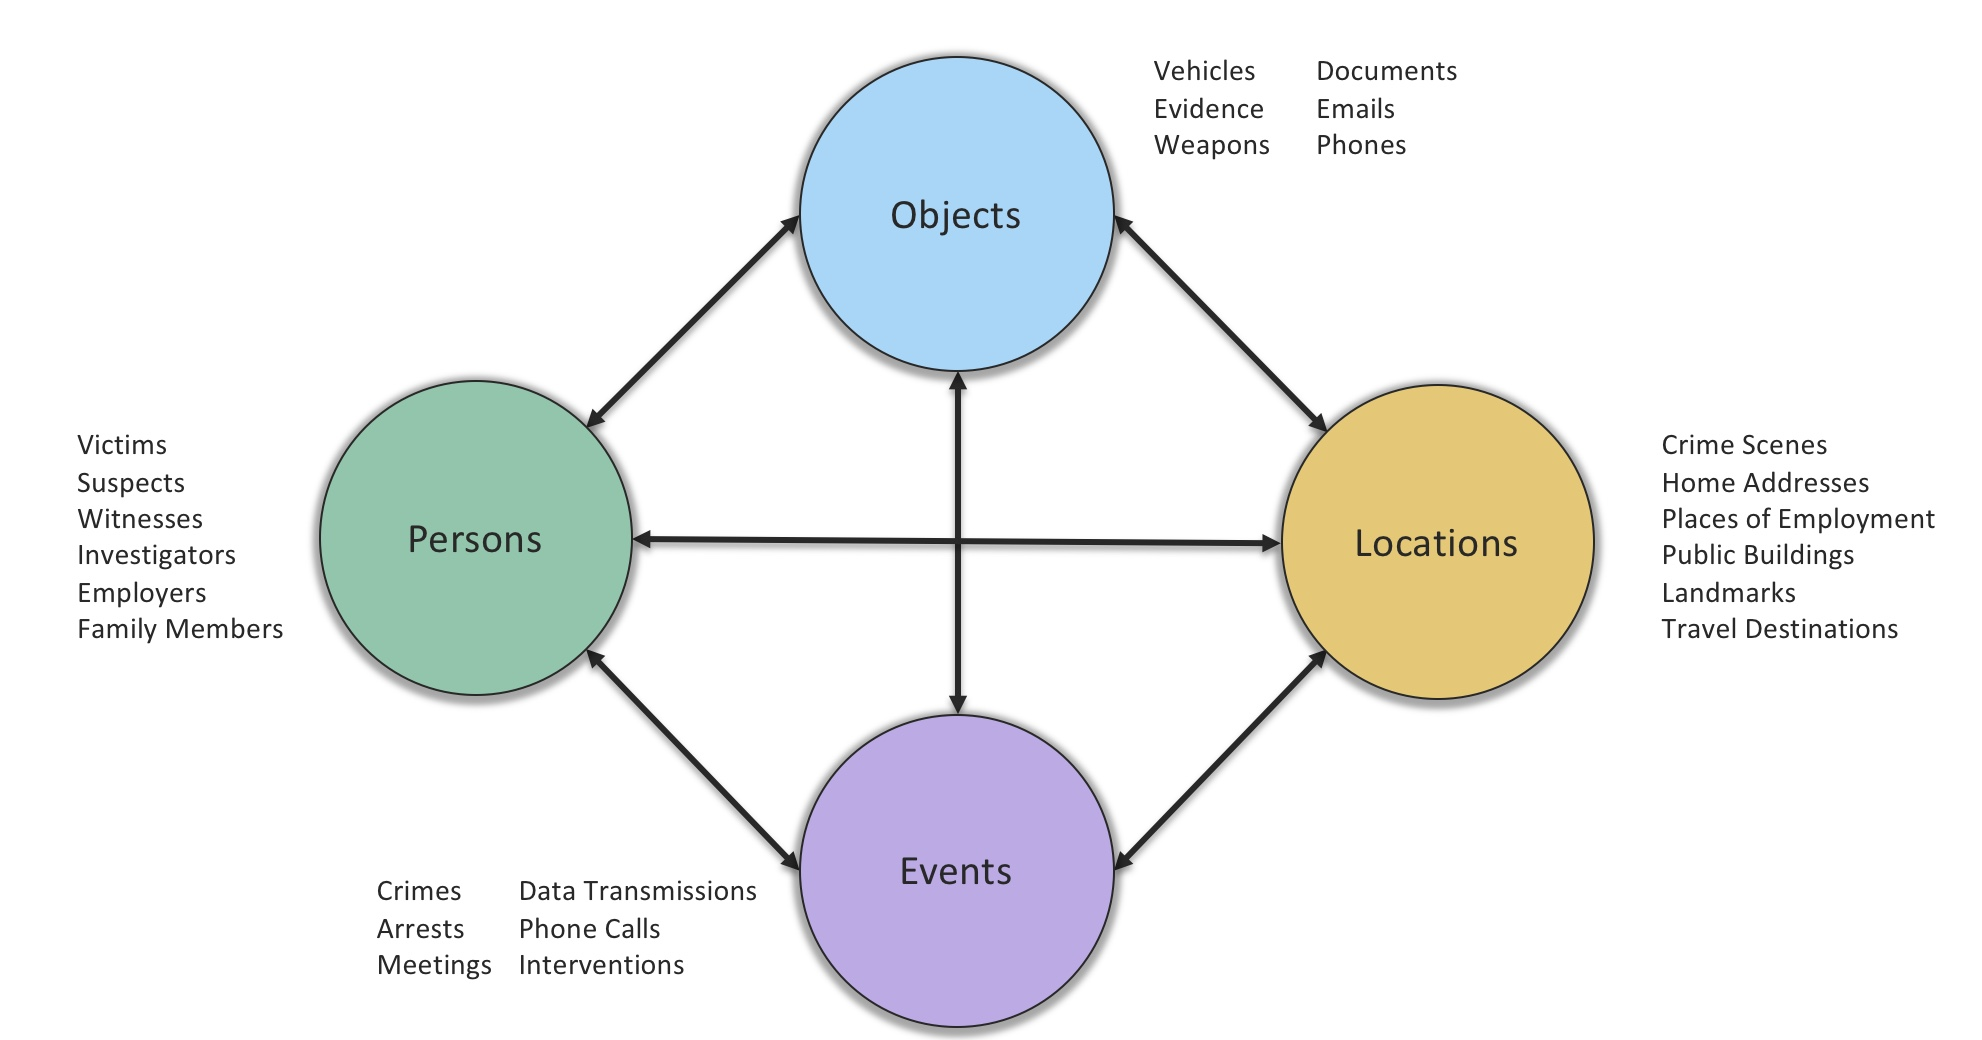

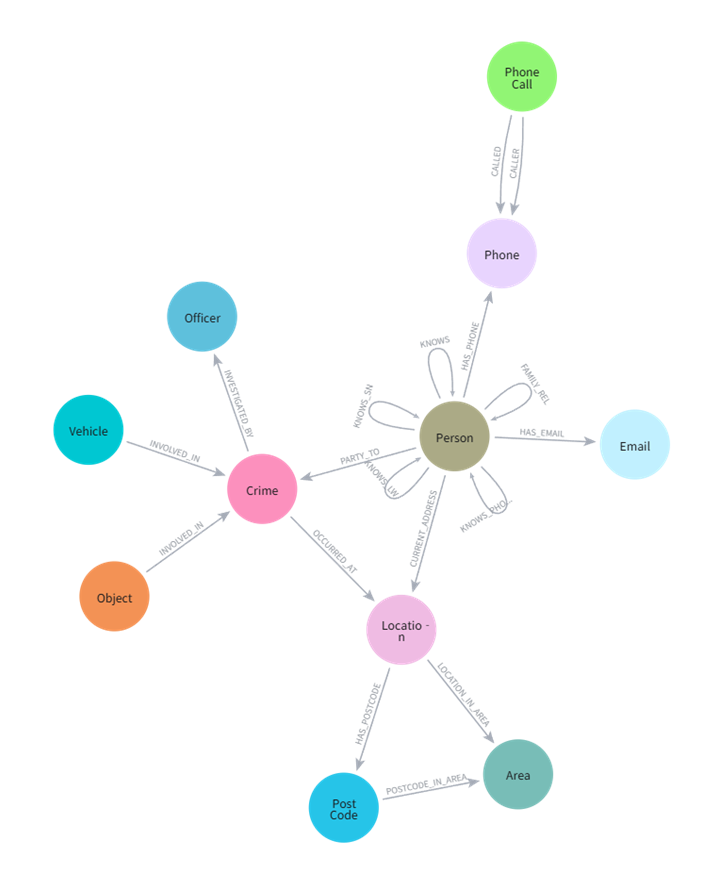

🪄 **Text2Cypher Examples**:

```SQL
USER INPUT: Piccadilly에서 발생한 범죄 건수는?
QUERY: MATCH (c:Crime)-[:OCCURRED_AT]->(l:Location {address: 'Piccadilly'})
RETURN count(c) AS crime_count


USER INPUT: M22 8ER 우편번호 지역의 범죄 유형 분포는?
QUERY: MATCH (pc:PostCode {code: "M22 8ER"})<-[:HAS_POSTCODE]-(l:Location)<-[:OCCURRED_AT]-(c:Crime)
RETURN c.type, count(*) AS count
ORDER BY count DESC


USER INPUT: 주로 어느 지역에서 차량 범죄가 많이 발생하나요?
QUERY: MATCH (v:Vehicle)-[:INVOLVED_IN]->(c:Crime)-[:OCCURRED_AT]->(l:Location)
RETURN l.address AS location, count(c) AS vehicle_crime_count
ORDER BY vehicle_crime_count DESC
LIMIT 5


USER INPUT: 어느 주소(또는 지역/우편번호)에서 범죄가 가장 많이 발생했나요?
QUERY: MATCH (l:Location)<-[:OCCURRED_AT]-(:Crime)
RETURN l.address AS address, l.postcode AS postcode, count(l) AS total
ORDER BY count(l) DESC
LIMIT 15


USER INPUT: Larive 경관(badge no 26-5234182)이 수사 중인 사건은 무엇인가요?
QUERY: MATCH (c:Crime {last_outcome: 'Under investigation'})-[i:INVESTIGATED_BY]->(o:Officer {badge_no: '26-5234182', surname: 'Larive'})
return *


USER INPUT: 범죄 관련자는 아니지만, 위험한 지인을 가장 많이 알고 있는 사람을 알려주세요.
QUERY: MATCH (p:Person)-[:KNOWS]-(friend)-[:PARTY_TO]->(:Crime)
WHERE NOT (p:Person)-[:PARTY_TO]->(:Crime)
RETURN p.name AS name, p.surname AS surname, p.nhs_no AS id, count(distinct friend) AS dangerousFriends
ORDER BY dangerousFriends DESC
LIMIT 5
```

### 2️⃣ Text2Cypher Retriever 사용하기

https://neo4j.com/docs/neo4j-graphrag-python/current/api.html#text2cypherretriever

#### DB 스키마 작성하기

- 첫번째 방법 : 노드, 관계 프로퍼티, 관계방향성

DB 스키마 예시: 

```text
Node properties:
Person {name: STRING, born: INTEGER}
Movie {tagline: STRING, title: STRING, released: INTEGER}
Relationship properties:
ACTED_IN {roles: LIST}
REVIEWED {summary: STRING, rating: INTEGER}
The relationships:
(:Person)-[:ACTED_IN]->(:Movie)
(:Person)-[:DIRECTED]->(:Movie)
(:Person)-[:PRODUCED]->(:Movie)
(:Person)-[:WROTE]->(:Movie)
(:Person)-[:FOLLOWS]->(:Person)
(:Person)-[:REVIEWED]->(:Movie)
```

In [5]:
from collections import defaultdict

def get_schema():
    schema = ""
    with driver.session() as session:
        # 모든 노드 라벨과 속성 추출
        node_schema = session.run("""
        CALL db.schema.nodeTypeProperties() YIELD nodeType, propertyName, propertyTypes
        RETURN nodeType, propertyName, propertyTypes
        """)

        nodes = defaultdict(dict)
        for record in node_schema:
            label = record["nodeType"].replace(":", "")
            prop = record["propertyName"]
            types = record["propertyTypes"]
            nodes[label][prop] = types[0] if types else "UNKNOWN"

        # 모든 관계 타입과 속성 추출
        rel_schema = session.run("""
        CALL db.schema.relTypeProperties() YIELD relType, propertyName, propertyTypes
        RETURN relType, propertyName, propertyTypes
        """)

        relationships = defaultdict(dict)
        for record in rel_schema:
            rel = record["relType"]
            prop = record["propertyName"]
            types = record["propertyTypes"]
            relationships[rel][prop] = types[0] if types else "UNKNOWN"

        # 관계 방향 및 타입 추출
        rel_types = session.run("""
        MATCH (a)-[r]->(b)
        RETURN DISTINCT labels(a) AS from_labels, type(r) AS rel_type, labels(b) AS to_labels
        """)

        rel_directions = set()
        for record in rel_types:
            from_label = f":{record['from_labels'][0]}"
            to_label = f":{record['to_labels'][0]}"
            rel_type = record['rel_type']
            rel_directions.add(f"({from_label})-[:{rel_type}]->({to_label})")

    # 출력
    schema += "\nNode properties:\n"
    for label, props in nodes.items():
        prop_str = ", ".join(f"{k}: {v}" for k, v in props.items())
        schema += f"{label} {{{prop_str}}}\n"

    schema += "\nRelationship properties:\n"
    for rel, props in relationships.items():
        prop_str = ", ".join(f"{k}: {v}" for k, v in props.items())
        schema += f"{rel} {{{prop_str}}}\n"

    schema += "\nThe relationships:\n"
    for rel in sorted(rel_directions):
        schema += f"{rel}\n"
    return schema

schema = get_schema()

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Procedure.ProcedureWarning} {category: GENERIC} {title: The query used a procedure that generated a warning.} {description: The query used a procedure that generated a warning. (The field `propertyTypes` will change output format in the next major version.)} {position: line: 2, column: 9, offset: 9} for query: '\n        CALL db.schema.nodeTypeProperties() YIELD nodeType, propertyName, propertyTypes\n        RETURN nodeType, propertyName, propertyTypes\n        '
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Procedure.ProcedureWarning} {category: GENERIC} {title: The query used a procedure that generated a warning.} {description: The query used a procedure that generated a warning. (The field `propertyTypes` will change output format in the next major version.)} {position: line: 2, column: 9, offset: 9} for query: '\n        CALL db.schema.relTypePropert

In [6]:
print(schema)


Node properties:
`PostCode` {code: String}
`Location` {latitude: Double, longitude: Double, address: String, postcode: String}
`Phone` {phoneNo: String}
`Email` {email_address: String}
`Area` {areaCode: String}
`PhoneCall` {call_duration: String, call_time: String, call_date: String, call_type: String}
`Officer` {surname: String, name: String, badge_no: String, rank: String}
`Crime` {date: String, id: String, type: String, last_outcome: String, note: String, charge: String}
`Vehicle` {model: String, reg: String, make: String, year: String}
`Object` {id: String, type: String, description: String}
`Person` {surname: String, nhs_no: String, name: String, age: String}

Relationship properties:
:`CURRENT_ADDRESS` {None: UNKNOWN}
:`HAS_POSTCODE` {None: UNKNOWN}
:`POSTCODE_IN_AREA` {None: UNKNOWN}
:`HAS_PHONE` {None: UNKNOWN}
:`HAS_EMAIL` {None: UNKNOWN}
:`KNOWS_SN` {None: UNKNOWN}
:`KNOWS` {None: UNKNOWN}
:`INVOLVED_IN` {None: UNKNOWN}
:`CALLER` {None: UNKNOWN}
:`CALLED` {None: UNKNOWN}
:`K

- 두번째 방법 : JSON

In [7]:
from collections import defaultdict

def extract_schema_json():
    with driver.session() as session:
        # 노드 정보 추출
        node_data = session.run("""
        CALL db.schema.nodeTypeProperties() YIELD nodeType, propertyName, propertyTypes
        RETURN nodeType, propertyName, propertyTypes
        """)

        entities = defaultdict(list)
        for record in node_data:
            label = record["nodeType"].replace(":", "")
            property_name = record["propertyName"]
            property_type = record["propertyTypes"][0] if record["propertyTypes"] else "UNKNOWN"
            entities[label].append({
                "name": property_name,
                "type": property_type,
                "description": ""  # ← 수동 설명 입력 가능
            })

        # 관계 정보 추출
        rel_data = session.run("""
        CALL db.relationshipTypes() YIELD relationshipType
        RETURN relationshipType
        """)

        relations = []
        for record in rel_data:
            rel_type = record["relationshipType"]
            relations.append({
                "label": rel_type,
                "description": ""  # ← 수동 설명 입력 가능
            })

        # 결과 구성
        schema_json = {
            "entities": [
                {
                    "label": label,
                    "description": "",  # ← 수동 설명 입력 가능
                    "properties": props
                }
                for label, props in entities.items()
            ],
            "relations": relations
        }

        return schema_json

# 출력
import json
schema = extract_schema_json()
print(json.dumps(schema, indent=4))

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Procedure.ProcedureWarning} {category: GENERIC} {title: The query used a procedure that generated a warning.} {description: The query used a procedure that generated a warning. (The field `propertyTypes` will change output format in the next major version.)} {position: line: 2, column: 9, offset: 9} for query: '\n        CALL db.schema.nodeTypeProperties() YIELD nodeType, propertyName, propertyTypes\n        RETURN nodeType, propertyName, propertyTypes\n        '


{
    "entities": [
        {
            "label": "`PostCode`",
            "description": "",
            "properties": [
                {
                    "name": "code",
                    "type": "String",
                    "description": ""
                }
            ]
        },
        {
            "label": "`Location`",
            "description": "",
            "properties": [
                {
                    "name": "latitude",
                    "type": "Double",
                    "description": ""
                },
                {
                    "name": "longitude",
                    "type": "Double",
                    "description": ""
                },
                {
                    "name": "address",
                    "type": "String",
                    "description": ""
                },
                {
                    "name": "postcode",
                    "type": "String",
                    "description": ""
      

#### Text2Cypher Retriever로 검색하기

In [8]:
from neo4j import GraphDatabase
from neo4j_graphrag.retrievers import Text2CypherRetriever
from neo4j_graphrag.llm import OpenAILLM

neo4j_schema = get_schema() # get_schema() str(extract_schema_json())

examples = [
    """
    USER INPUT: Piccadilly에서 발생한 범죄 건수는?
    QUERY: MATCH (c:Crime)-[:OCCURRED_AT]->(l:Location {address: 'Piccadilly'})
    RETURN count(c) AS crime_count

    USER INPUT: M22 8ER 우편번호 지역의 범죄 유형 분포는?
    QUERY: MATCH (pc:PostCode {code: "M22 8ER"})<-[:HAS_POSTCODE]-(l:Location)<-[:OCCURRED_AT]-(c:Crime)
    RETURN c.type, count(*) AS count
    ORDER BY count DESC

    USER INPUT: Larive 경관(badge no 26-5234182)이 수사 중인 사건은 무엇인가요?
    QUERY: MATCH (c:Crime {last_outcome: 'Under investigation'})-[i:INVESTIGATED_BY]->(o:Officer {badge_no: '26-5234182', surname: 'Larive'})
    return *
    """
]

retriever = Text2CypherRetriever(
    driver=driver,
    llm=llm,  # type: ignore
    neo4j_schema=neo4j_schema,
    examples=examples,
)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Procedure.ProcedureWarning} {category: GENERIC} {title: The query used a procedure that generated a warning.} {description: The query used a procedure that generated a warning. (The field `propertyTypes` will change output format in the next major version.)} {position: line: 2, column: 9, offset: 9} for query: '\n        CALL db.schema.nodeTypeProperties() YIELD nodeType, propertyName, propertyTypes\n        RETURN nodeType, propertyName, propertyTypes\n        '
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Procedure.ProcedureWarning} {category: GENERIC} {title: The query used a procedure that generated a warning.} {description: The query used a procedure that generated a warning. (The field `propertyTypes` will change output format in the next major version.)} {position: line: 2, column: 9, offset: 9} for query: '\n        CALL db.schema.relTypePropert

In [12]:
query_text = "현재 수사 중인 범죄 사건의 개수는?"
result = retriever.search(query_text=query_text)

In [13]:
result.items

[RetrieverResultItem(content='<Record investigating_crime_count=3421>', metadata=None)]

In [14]:
print(result.metadata["cypher"])

MATCH (c:Crime {last_outcome: 'Under investigation'})
RETURN count(c) AS investigating_crime_count


### 3️⃣ GraphRAG 파이프라인 모듈 사용하기

In [21]:
from neo4j_graphrag.llm.openai_llm import OpenAILLM
from neo4j_graphrag.generation import GraphRAG

llm = OpenAILLM(model_name="gpt-4o")
graph_rag = GraphRAG(retriever, llm)

In [31]:
query = "범죄자는 아니지만, 범죄자를 많이 알고 있는 사람은?"
response = graph_rag.search(query_text=query, return_context = True)

In [32]:
print("## 생성 답변 ##\n" + response.answer)
print("\n## Cypher ##\n" + response.retriever_result.metadata["cypher"])
print("\n## 검색 결과 ##")
for i in response.retriever_result.items: print(i.content)

## 생성 답변 ##
범죄자는 아니지만, 범죄자를 많이 알고 있는 사람은 Anne Freeman입니다. 그녀는 7명의 범죄자를 알고 있습니다.

## Cypher ##
MATCH (p:Person)-[:KNOWS]->(criminal:Person)-[:PARTY_TO]->(c:Crime)
WITH p, count(DISTINCT criminal) AS known_criminals
WHERE known_criminals > 1
RETURN p.name, p.surname, known_criminals
ORDER BY known_criminals DESC

## 검색 결과 ##
<Record p.name='Anne' p.surname='Freeman' known_criminals=7>
<Record p.name='Bonnie' p.surname='Gilbert' known_criminals=6>
<Record p.name='Ashley' p.surname='Robertson' known_criminals=3>
<Record p.name='Jessica' p.surname='Kelly' known_criminals=3>
<Record p.name='Brian' p.surname='Morales' known_criminals=3>
<Record p.name='Walter' p.surname='James' known_criminals=2>
<Record p.name='Phillip' p.surname='Williamson' known_criminals=2>
<Record p.name='Alan' p.surname='Ward' known_criminals=2>
